In [27]:
import spectral as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

sys.path.append('../')
from preprocessing import *
from plotting_parameters import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.use("wxAgg")
%matplotlib inline
set_plotting_style("latex")
# set_plotting_style("default")

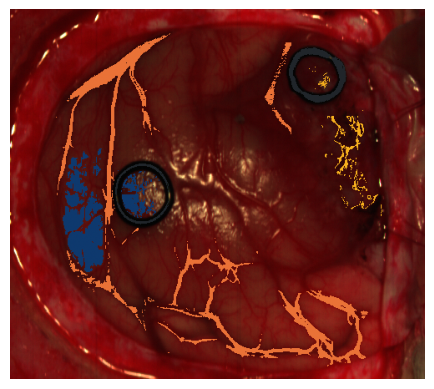

In [28]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_1]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

fig = plot_img(img, gt_map, class_labels, class_colors, legend=False)


preprocess image

In [29]:
bands_range = bands_range = [450,900]
img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=2, ord=1, keepdims=True)
img_smooth = smooth_spectral(img_calib_norm, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

Plot examplary spectra from image before and after preprocessing

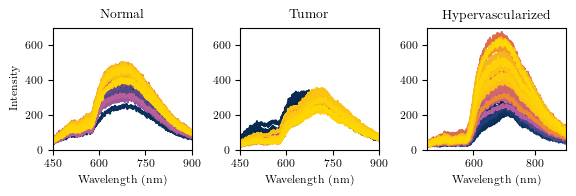

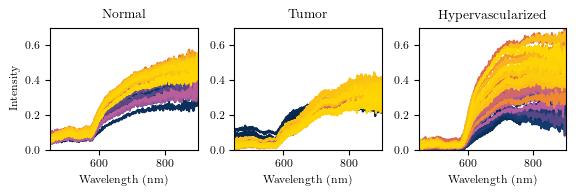

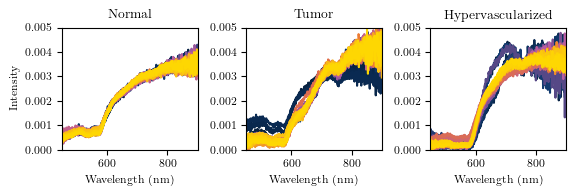

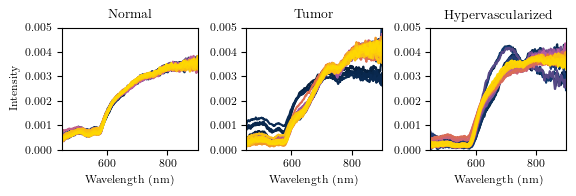

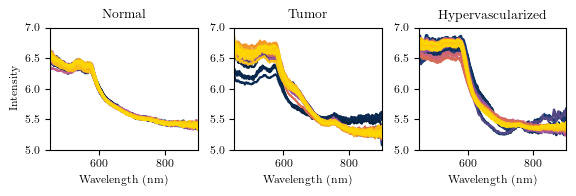

In [32]:
nspectra = 50

# plot raw spectra
fig, axs = plot_class_spectra(img, gt_map, nspectr=nspectra, bands=img.bands.centers, figsize=(5.8,2))
# fig.suptitle('Pixel spectra of raw image')
axs[0].set_ylabel('Intensity')
axs[0].set_xlim([450, 900])
axs[0].set_xticks([450, 600, 750, 900])
axs[0].set_ylim([0, 700])
axs[1].set_xlim([450, 900])
axs[1].set_xticks([450, 600, 750, 900])
axs[1].set_ylim([0, 700])
axs[2].set_xlim([450, 900])
axs[2].set_ylim([0, 700])
plt.tight_layout()
# plt.savefig("../../figures/raw_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot calibrated spectra
fig, axs = plot_class_spectra(img_calib, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# fig.suptitle('Pixel spectra of calibrated image')
axs[0].set_ylabel('Intensity')
axs[0].set_xlim([450, 900])
axs[0].set_ylim([0, 0.7])
axs[1].set_xlim([450, 900])
axs[1].set_ylim([0, 0.7])
axs[2].set_xlim([450, 900])
axs[2].set_ylim([0, 0.7])
plt.tight_layout()
# plt.savefig("../../figures/calib_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot calibrated + normalized spectra
fig, axs = plot_class_spectra(img_calib_norm, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# fig.suptitle('Pixel spectra of calibrated and normalized image')
axs[0].set_ylabel('Intensity')
axs[0].set_xlim([450, 900])
axs[0].set_ylim([0, 0.005])
axs[1].set_xlim([450, 900])
axs[1].set_ylim([0, 0.005])
axs[2].set_xlim([450, 900])
axs[2].set_ylim([0, 0.005])
plt.tight_layout()
# plt.savefig("../../figures/calib_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot calibrated + normalized + smoothed
fig, axs = plot_class_spectra(img_smooth, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# fig.suptitle('Pixel spectra of calibrated and normalized image')
axs[0].set_ylabel('Intensity')
axs[0].set_xlim([450, 900])
axs[0].set_ylim([0, 0.005])
axs[1].set_xlim([450, 900])
axs[1].set_ylim([0, 0.005])
axs[2].set_xlim([450, 900])
axs[2].set_ylim([0, 0.005])
plt.tight_layout()
# plt.savefig("../../figures/calib_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot absorbance
fig, axs = plot_class_spectra(absorbance, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2), legend_loc='upper right')
# fig.suptitle('Pixel spectra of absorbance')
axs[0].set_ylabel('Intensity')
axs[0].set_xlim([450, 900])
axs[0].set_ylim([5,7])
axs[1].set_xlim([450, 900])
axs[1].set_ylim([5,7])
axs[2].set_xlim([450, 900])
axs[2].set_ylim([5,7])
plt.tight_layout()
# plt.savefig("../../figures/absorbance_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

Plot class-wise mean spectra and bands from image before and after preprocessing

In [37]:
def plot_class_dist(img, gt_map, bands, class_ids, class_labels, class_colors, figsize=(5,4), legend_loc='upper left'):
    '''
    Plot the spectral mean and std of the specified classes.
    input:
        img: image to plot, SpyFile or array-like
        gt_map: ground truth map, np.array or SpyFile
        bands: band centers, list of floats
        class_ids: class ids to plot, list of ints
        class_labels: class names, list of strings
        class_colors: colors to use for plotting, list of strings
        figsize: figure size, tuple of floats
        legend_loc: location of the legend, string or None if no legend should be plotted
    output:
        fig: figure handle to the plot
        ax: axis handle to the plot
    '''
    img = get_array(img)
    gt_map = gt_map.asarray()

    fig, ax = plt.subplots(figsize=figsize)
    for class_id in class_ids:
        mask = np.where(gt_map[:, :, 0] == class_id)
        class_std = np.std(img[mask], axis=0)
        class_mean = np.mean(img[mask], axis=0)
        ax.plot(bands, class_mean, label=class_labels[class_id], color=class_colors[class_id])
        ax.fill_between(bands, class_mean - class_std, class_mean + class_std, alpha=0.25, color=class_colors[class_id])
    ax.set_xlim([bands[0], bands[-1]])
    ax.set_ylabel('Intensity')
    ax.set_xlabel('Wavelength (nm)')
    if legend_loc is not None:
        # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        order = [0,2,1]
        handles, labels = plt.gca().get_legend_handles_labels()
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=legend_loc, handlelength=0.8, borderaxespad=0.5)
        # ax.legend(loc=legend_loc, handlelength=0.8, borderaxespad=0.)
    return fig, ax

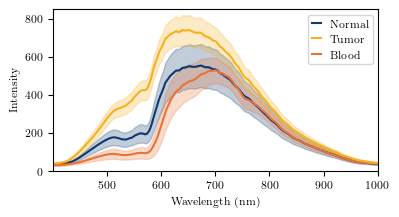

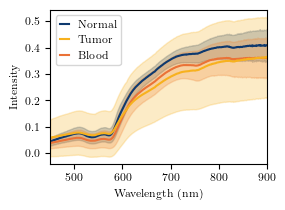

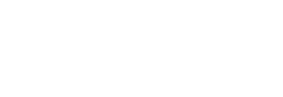

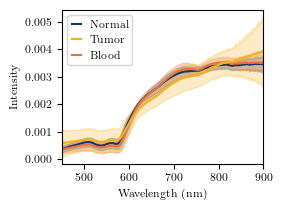

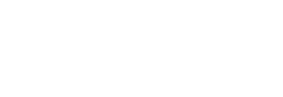

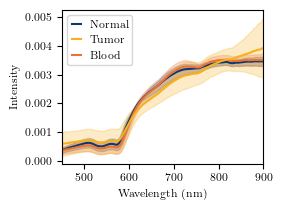

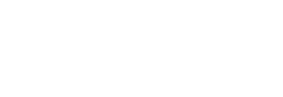

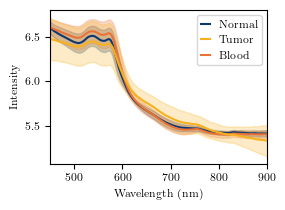

In [50]:
# plot mean raw spectra
fig, ax = plot_class_dist(img, gt_map, img.bands.centers, [1,3,2], class_labels, class_colors, figsize=(4.2,2.1), legend_loc='upper right')
ax.set_ylim([0, 850])
# fig.suptitle('Mean pixel spectra of raw image')
plt.savefig("../../figures/raw_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# plot mean calibrated spectra
fig, ax = plot_class_dist(img_calib, gt_map, band_centers, [1,3,2], class_labels, class_colors, figsize=(2.8,2), legend_loc='upper left')
# fig.suptitle('Mean pixel spectra of calibrated image')
# plt.savefig("../figures/calib_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')
plot_ref_half()

# plot mean calibrated and normalized spectra
fig, ax = plot_class_dist(img_calib_norm, gt_map, band_centers, [1,3,2], class_labels, class_colors, figsize=(2.6,2), legend_loc='upper left')
# fig.suptitle('Mean pixel spectra of calibrated and normalized image')
# plt.savefig("../figures/calib_norm_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')
plot_ref_half()

# plot mean calibrated and normalized and smoothed spectra
fig, ax = plot_class_dist(img_smooth, gt_map, band_centers, [1,3,2], class_labels, class_colors, figsize=(2.6,2), legend_loc='upper left')
# fig.suptitle('Mean pixel spectra of calibrated and normalized and smoothed image')
# plt.savefig("../figures/calib_norm_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')
plot_ref_half()

# plot mean absorbance
fig, ax = plot_class_dist(absorbance, gt_map, band_centers, [1,3,2], class_labels, class_colors, figsize=(2.8,2), legend_loc='upper right')
# fig.suptitle('Mean pixel spectra of absorbance')
# plt.savefig("../figures/absorbance_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

plot example bands

In [39]:
def plot_bands(img, bands=[200, 300, 400, 500, 600, 700], figsize=(18,3)):
    '''
    Plot selected bands of the image as gray-scale images. 
    The contrast is increased by setting the maximum value to the 99.9th percentile.
    input:
        img: spectral.ImageArray or np.array containing the image
        bands: list of bands to plot
        figsize: size of the figure
    output:
        fig: figure with plot
        axs: axes with plots
    '''
    img = get_array(img)
    fig, axs = plt.subplots(1, len(bands), figsize=figsize)
    for i, band in enumerate(bands):
        img_band = img[:,:,band]
        img_band = (img_band - np.min(img_band)) / (np.max(img_band) - np.min(img_band))
        vmax = np.percentile(img_band, 99)
        axs[i].imshow(img_band, cmap='gray', aspect='equal', vmin=0, vmax=vmax)
        axs[i].set_title(f'Band {band}')
        axs[i].axis('off')
    return fig, axs

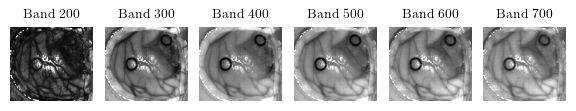

In [40]:
# plot raw image for different bands
fig, axs = plot_bands(img.asarray(), figsize=(5.8,2))
# fig.suptitle('Raw image for different bands')
plt.tight_layout()
# plt.savefig("../../figures/raw_bands_images_helicoid_12-01.svg", format='svg', bbox_inches='tight')

Per-class distribution of multiple images

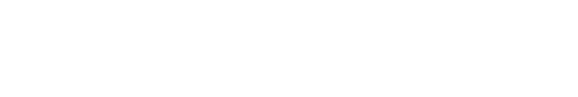

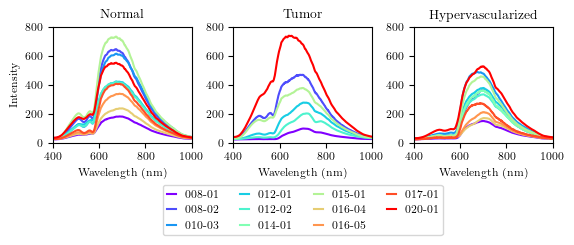

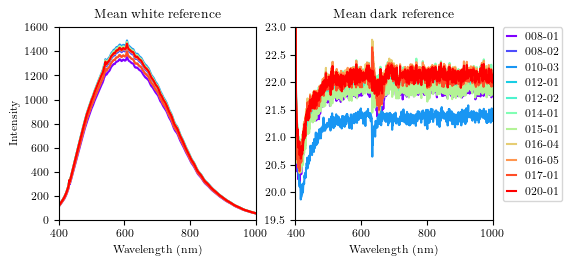

In [46]:
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
data_folder = "../../datasets/helicoid/"
gradeIVpatients = ["008-01", "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01"] 
class_ids = [1, 2, 3]

colors = mpl.cm.rainbow(np.linspace(0, 1, len(gradeIVpatients)))
# colors = tum_cmap(np.linspace(0, 1, len(gradeIVpatients)))


# fig0, axs0 = plt.subplots(1, len(class_ids), figsize=(18,5))
# fig1, axs1 = plt.subplots(1, len(class_ids), figsize=(18,5))
plot_ref_full()
fig2, axs2 = plt.subplots(1, len(class_ids), figsize=(6.45,1.5))
# fig3, axs3 = plt.subplots(1, len(class_ids), figsize=(18,5))
# fig4, axs4 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig_white_dark, axs_white_dark = plt.subplots(1,2, figsize=(5.6,2.5))

for n, patient in enumerate(gradeIVpatients):
    
    patient_folder = data_folder + patient + "/"
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr")
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr")
    gt_map = sp.open_image(patient_folder + "/gtMap.hdr")
    # img_proj = project_img(img.asarray(), white_ref, dark_ref)
    # img_proj_norm = img_proj/np.linalg.norm(img_proj, axis=2, ord=1, keepdims=True)
    
    # img_processed = calibrate_img(img, white_ref, dark_ref)
    # img_processed, band_centers = band_removal(img_processed, [450.0, 900.0], img.bands.centers)
    # img_processed = smooth_spectral(img_processed)
    # img_processed = normalize_spectral_interval(img_processed)
    # img_norm = normalize_spectral_interval_mean(img_processed, class_wise=True, gt_map=gt_map)
    # img_processed_advanced = calibrate_img_advanced(img, white_ref, dark_ref, average_ref_pixels=True)
    # img_processed_advanced, _ = band_removal(img_processed_advanced, [450.0, 900.0], img.bands.centers)


    # plot mean spectra (processed and raw) for each class
    for i, class_id in enumerate(class_ids):
        mask = np.where(gt_map.asarray()[:,:,0] == class_id)
        if len(mask[0]) == 0: 
            # axs0[i].plot([], [], color=colors[n], label=patient) # Plot an empty line to consume a color
            # axs1[i].plot([], [], color=colors[n], label=patient)  
            axs2[i].plot([], [], color=colors[n], label=patient)
            # axs3[i].plot([], [], color=colors[n], label=patient)
            # axs4[i].plot([], [], color=colors[n], label=patient)
            continue
        # axs0[i].plot(img.bands.centers, np.mean(img_processed_advanced[mask], axis=0), color=colors[n], label=patient)
        # axs1[i].plot(img.bands.centers, np.mean(img_processed[mask], axis=0), color=colors[n], label=patient)
        axs2[i].plot(img.bands.centers, np.mean(img.asarray()[mask], axis=0), color=colors[n], label=patient)
        # axs3[i].plot(img.bands.centers, np.mean(img_proj[mask], axis=0), color=colors[n], label=patient)
        # axs4[i].plot(img.bands.centers, np.mean(img_proj_norm[mask], axis=0), color=colors[n], label=patient)
        
    # plot white and dark references for patient
    axs_white_dark[0].plot(img.bands.centers, np.mean(white_ref.asarray(), axis=(0,1)), color=colors[n], label=patient)
    axs_white_dark[1].plot(img.bands.centers, np.mean(dark_ref.asarray(), axis=(0,1)), color=colors[n], label=patient)

# fig0.suptitle("Normalized (Advanced normalization)")
# axs0[0].set_title("Normal")
# axs0[1].set_title("Tumor")
# axs0[2].set_title("Hypervascularized")
# axs0[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

# fig1.suptitle("Normalized (Standard normalization))")
# axs1[0].set_title("Normal")
# axs1[1].set_title("Tumor")
# axs1[2].set_title("Hypervascularized")
# axs1[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

# fig2.suptitle("Raw")
axs2[0].set_title("Normal")
axs2[1].set_title("Tumor")
axs2[2].set_title("Hypervascularized")
axs2[0].set_xlabel('Wavelength (nm)')
axs2[0].set_ylabel('Intensity')
axs2[1].set_xlabel('Wavelength (nm)')
axs2[2].set_xlabel('Wavelength (nm)')
axs2[0].set_xlim([400,1000])
axs2[1].set_xlim([400,1000])
axs2[2].set_xlim([400,1000])
axs2[0].set_ylim([0,800])
axs2[1].set_ylim([0,800])
axs2[2].set_ylim([0,800])
fig2.subplots_adjust(wspace=0.3)
# fig2.tight_layout()
axs2[1].legend(bbox_to_anchor=(0.5, -.8), loc='lower center', borderaxespad=0., ncol=4, handlelength=0.8)
# fig2.savefig("../../figures/raw_class_mean_helicoid.svg", format='svg', bbox_inches='tight')

axs_white_dark[0].set_title("Mean white reference")
axs_white_dark[1].set_title("Mean dark reference")
axs_white_dark[0].set_ylabel('Intensity')
axs_white_dark[0].set_xlabel('Wavelength (nm)')
axs_white_dark[1].set_xlabel('Wavelength (nm)')
axs_white_dark[0].set_xlim([400,1000])
axs_white_dark[1].set_xlim([400,1000])
axs_white_dark[0].set_ylim([0,1600])
axs_white_dark[1].set_ylim([19.5,23])
axs_white_dark[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., handlelength=0.8)
# fig_white_dark.savefig("../../figures/white_dark_mean_helicoid.svg", format='svg', bbox_inches='tight')